In [1]:
import sys
sys.path.append('../../ml_utils')

import config as cfg
import data_utils as du
import vis_utils as vis
import autoencoder as aenc
import timeit
import joblib

import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'

import tensorflow 

Using TensorFlow backend.
/home/administrator/anaconda3/envs/masterthesis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/administrator/anaconda3/envs/masterthesis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/administrator/anaconda3/envs/masterthesis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint1

In [2]:
print("Python: ", sys.version)
print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)

Python:  3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]
pandas:  0.25.3
numpy:  1.17.4
seaborn:  0.9.0
matplotlib:  3.1.1
sklearn:  0.22
Keras:  2.2.4
Tensorflow:  1.13.1


### Load and clean the data

In [3]:
log_data = './../../shared/data/swissid_authorize_logs_april_to_sept_2019.csv'

start = timeit.default_timer()
df = pd.read_csv(filepath_or_buffer=log_data, header=0, sep='\t', names=cfg.complete_feature_list, index_col=None)
stop = timeit.default_timer()

print("Original data frame size: {}\n".format(df.shape))
print("Time: {} seconds\n".format(stop - start))

Original data frame size: (12417597, 31)

Time: 40.52898728100001 seconds



In [4]:
df = du.clean_data(df)

columns with NaN: loc_country_code
loc_country_code is fixed


In [5]:
features = ['label_nr', 'src_software_sub_type', 'src_operating_system_name', 'src_hardware_type', 'response_status_code', 
            'oidc_client_id', 'oidc_scopes', 'oidc_ui_locales', 'loc_city', 'loc_country_code', 'date_weekday']

excludes = list(set(df.columns.tolist()) - set(features))

In [6]:
reduced_df = du.reduce_features(df, excludes)

print("reduced data frame size: {}\n".format(reduced_df.shape))
#display(reduced_df)

reduced data frame size: (12204748, 11)



In [7]:
print(reduced_df['label_nr'].value_counts())

2    7412813
0    4769169
1      22766
Name: label_nr, dtype: int64


### Model Training

In [8]:
sample_size= 500000
exclude = ['label_nr']

# load dataset
X_df, y_df, anomaly_rate, encoder = du.build_normal_anomaly_sample_df(reduced_df, sample_size, exclude, True, True, False, True)
x_train, x_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42)

print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(350000, 10) train samples
(150000, 10) test samples


In [9]:
#sparse autoencoder
encoding_dim = 4
model = aenc.create_simple_auto_encoder(x_train.shape[1], encoding_dim)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50        
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


In [10]:
batch_size = 32
epochs = 25
optimizer='Adamax'

history = aenc.auto_encoder_fit(model, x_train, x_test, optimizer, epochs, batch_size)

Instructions for updating:
Use tf.cast instead.
Train on 350000 samples, validate on 150000 samples
Epoch 1/25
350000/350000 [==============================] - 13s 36us/step - loss: 0.8602 - mean_absolute_error: 0.4858 - acc: 0.6507 - val_loss: 0.8431 - val_mean_absolute_error: 0.4774 - val_acc: 0.7735
Epoch 2/25
350000/350000 [==============================] - 12s 35us/step - loss: 0.8274 - mean_absolute_error: 0.4752 - acc: 0.8386 - val_loss: 0.8288 - val_mean_absolute_error: 0.4747 - val_acc: 0.9084
Epoch 3/25
350000/350000 [==============================] - 12s 35us/step - loss: 0.8224 - mean_absolute_error: 0.4736 - acc: 0.9031 - val_loss: 0.8271 - val_mean_absolute_error: 0.4739 - val_acc: 0.9135
Epoch 4/25
350000/350000 [==============================] - 12s 35us/step - loss: 0.8212 - mean_absolute_error: 0.4730 - acc: 0.9085 - val_loss: 0.8262 - val_mean_absolute_error: 0.4736 - val_acc: 0.9229
Epoch 5/25
350000/350000 [==============================] - 12s 35us/step - loss: 0.

In [11]:
score = model.evaluate(x_test, x_test, verbose=1)

for i, metric in enumerate(model.metrics_names):
    print('Test ' + metric + ':', score[i])

150000/150000 [==============================] - 1s 9us/step
Test loss: 0.8236829058519999
Test mean_absolute_error: 0.47226097841262815
Test acc: 0.93956


# Model Evaluation

## Model Loss

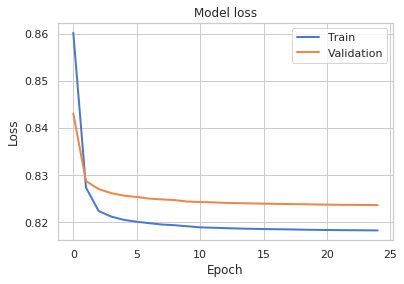

In [12]:
sns.set(style='whitegrid', palette='muted', font_scale=1.0)

plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Validation')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

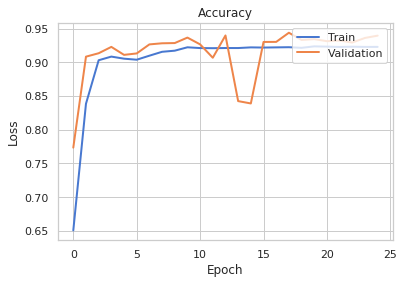

In [13]:
sns.set(style='whitegrid', palette='muted', font_scale=1.0)

plt.plot(history.history['acc'], linewidth=2, label='Train')
plt.plot(history.history['val_acc'], linewidth=2, label='Validation')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

## Reconstruction Error Check

In [14]:
x_test_predictions = model.predict(x_test)
mse = np.mean(np.power(x_test - x_test_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})
error_df.describe()

,Reconstruction_error,True_class
count,150000.000000,150000.00000
mean,0.823683,0.00492
std,4.240590,0.06997
min,0.060301,0.00000
25%,0.198187,0.00000
50%,0.317562,0.00000
75%,0.482319,0.00000
max,264.684619,1.00000


## ROC Curve Check

Receiver operating characteristic curves are an expected output of most binary classifiers. Since we have an imbalanced data set they are somewhat less useful. Why? Because you can generate a pretty good-looking curve by just simply guessing everything is the normal case because there are so proportionally few cases of fraud. Without getting into detail, this is something called the Accuracy Paradox.

In [15]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

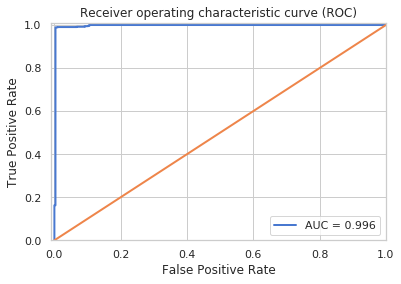

In [16]:
fpr, tpr, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=2)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Recall vs. Precision Thresholding

Precision and recall are the eternal tradeoff in data science, so at some point you have to draw an arbitrary line, or a threshold. Where this line will be drawn is essentially a business decision. In this case, you are trading off the cost between missing a fraudulent transaction and the cost of falsely flagging the transaction as a fraudulent even when it is not. Add those two weights to the calculation and you can come up with some theoretical optimal solution. This is rarely the way it is done in practice, however, as it is hard to quantify a lot of those costs (such as customer annoyance at getting fraud alerts too frequently), or because of various structural, technical, or business rules preventing the optimized solution from being chosen.

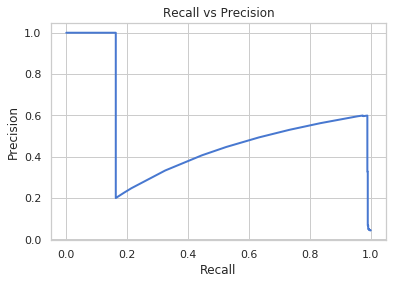

In [17]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)

plt.plot(recall_rt, precision_rt, linewidth=2, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

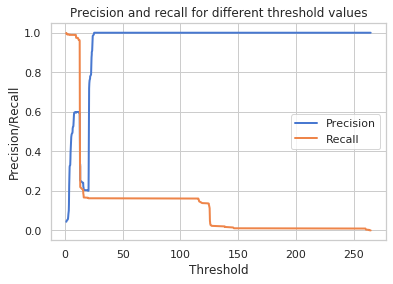

In [18]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## Balance of Data Visualization

In [22]:
y_pred = model.predict(x_test)

In [37]:
thres, f1_max, p, r, sup, acc = aenc.calc_metrics(x_test, y_test, y_pred)

print("threshold: {}".format(thres))
print("F1-Score: {}".format(f1_max))
print("Precision: {}".format(p))
print("Recall: {}".format(r))
print("Support: {}".format(sup))
print("Accuracy: {}".format(acc))

/home/administrator/anaconda3/envs/masterthesis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


threshold: 9.699999999999982
F1-Score: 0.7460398569238631
Precision: 0.5988515176374077
Recall: 0.989159891598916
Support: 738
Accuracy: 0.9966866666666667


In [35]:
y_class, errors = aenc.classify(x_test, y_pred, thres)

In [36]:
roc_auc_score(y_test, y_class)

0.9929418865479405

## Confusion Matrix

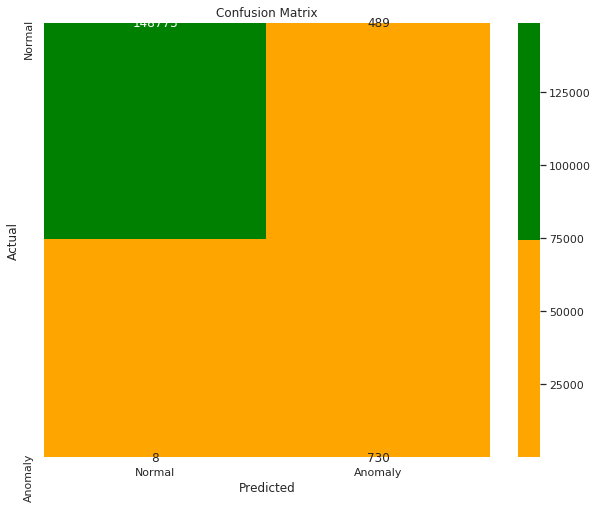

In [28]:
viz = vis.Visualization()

viz.draw_confusion_matrix(y_test, y_class)
#viz.draw_confusion_matrix(y_val, y_class)

## Reconstruction Error vs Threshold Check

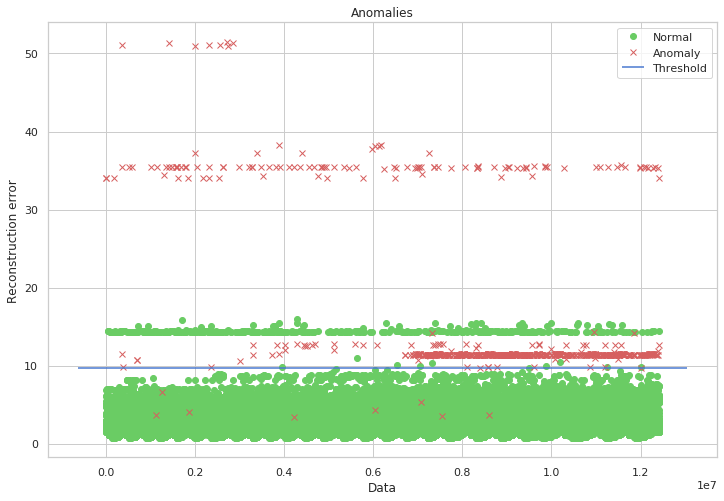

In [29]:
viz.draw_anomaly(y_test, errors, thres)
#viz.draw_anomaly(y_val, errors, thres)

In [30]:
path_model = './../../shared/models/autoencoder/simple_autoencoder_model.hdf5'
path_enc = './../../shared/models/autoencoder/simple_autoencoder_encoder_all.pkl'

model.save(path_model)
joblib.dump(encoder, path_enc)

['./../../shared/models/autoencoder/simple_autoencoder_encoder_all.pkl']